In [1]:
import torch

import torch.nn as nn

import matplotlib.pyplot as plt

import numpy as np

from IPython.display import HTML

from diffusion_utilities import ResidualConvBlock, UnetUp, UnetDown,EmbedFC,plot_sample

# Hyperparameters

# diffusion hyperparameters

timesteps = 500

beta1 = 1e-4

beta2 = 0.02

# network hyperparameters

device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))

n_feat = 64 # 64 hidden dimension feature

n_cfeat = 5 # context vector is of size 5

height = 16 # 16x16 image

In [2]:
# construct DDPM noise schedule

b_t = beta1 + ((beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device))


# Cumulative product of alphas: Defines how much original image information remains at time t and αˉt​ helps efficiently sample from any step.:
a_t = 1 - b_t

ab_t = torch.cumsum(a_t.log(), dim=0).exp()

ab_t[0] = 1

In [3]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10, height=28):  # cfeat - context features
        super(ContextUnet, self).__init__()

        # number of input channels, number of intermediate feature maps and number of classes
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.h = height  # assume h == w. must be divisible by 4, so 28,24,20,16...

        # Initialize the initial convolutional layer
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        # Initialize the down-sampling path of the U-Net with two levels
        self.down1 = UnetDown(n_feat, n_feat)  # down1 #[10, 256, 8, 8]
        self.down2 = UnetDown(n_feat, 2 * n_feat)  # down2 #[10, 256, 4, 4]

        # original: self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())
        self.to_vec = nn.Sequential(nn.AvgPool2d((4)), nn.GELU())

        # Embed the timestep and context labels with a one-layer fully connected neural network
        self.timeembed1 = EmbedFC(1, 2 * n_feat)
        self.timeembed2 = EmbedFC(1, 1 * n_feat)
        self.contextembed1 = EmbedFC(n_cfeat, 2 * n_feat)
        self.contextembed2 = EmbedFC(n_cfeat, 1 * n_feat)

        # Initialize the up-sampling path of the U-Net with three levels
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, self.h // 4, self.h // 4),  # up-sample
            nn.GroupNorm(8, 2 * n_feat),  # normalize
            nn.ReLU(),
        )
        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)

        # Initialize the final convolutional layers to map to the same number of channels as the input image
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),  # reduce number of feature maps
            nn.GroupNorm(8, n_feat),  # normalize
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),  # map to same number of channels as input
        )

    def forward(self, x, t, c=None):
        """
        x : (batch, n_feat, h, w) : input image
        t : (batch, n_cfeat) : time step
        c : (batch, n_classes) : context label
        """
        # x is the input image, c is the context label, t is the timestep
        # pass the input image through the initial convolutional layer
        x = self.init_conv(x)

        # pass the result through the down-sampling path
        down1 = self.down1(x)  # [10, 256, 8, 8]
        down2 = self.down2(down1)  # [10, 256, 4, 4]

        # convert the feature maps to a vector and apply an activation
        hiddenvec = self.to_vec(down2)

        # mask out context if context_mask == 1
        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x)

        # embed context and timestep
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)  # (batch, 2*n_feat, 1,1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1 * up1 + temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2 * up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))

        return out

# construct model
nn_model = ContextUnet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)

# helper function; removes the predicted noise (but adds some noise back in to avoid collapse)
def denoise_add_noise(x, t, pred_noise, z=None):
    if z is None:
        z = torch.randn_like(x)
    noise = b_t.sqrt()[t] * z
    mean = (x - pred_noise * ((1 - a_t[t]) / (1 - ab_t[t]).sqrt())) / a_t[t].sqrt()
    return mean + noise


In [4]:
# load in model weights and set to eval mode

save_dir = 'model/'

nn_model.load_state_dict(torch.load(f"{save_dir}/model_trained.pth", map_location=device))

nn_model.eval()

print("Loaded in Model")

# sample using standard algorithm

@torch.no_grad()

def sample_ddpm(n_sample, save_rate=20):

    # x_T ~ N(0, 1), sample initial noise

    samples = torch.randn(n_sample, 3, height, height).to(device)

    # array to keep track of generated steps for plotting

    intermediate = []

    for i in range(timesteps, 0, -1):

        print(f'sampling timestep {i:3d}', end='\r')

        # reshape time tensor

        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        # sample some random noise to inject back in. For i = 1, don't add back in noise

        z = torch.randn_like(samples) if i > 1 else 0

        eps = nn_model(samples, t)  # predict noise e_(x_t,t)

        samples = denoise_add_noise(samples, i, eps, z)

        if i % save_rate ==0 or i==timesteps or i<8:
            
            intermediate.append(samples.detach().cpu().numpy())

        
    intermediate = np.stack(intermediate)

    return samples, intermediate
#-------------------------------------------------------

# helper function; removes the predicted noise (but adds some noise back in to avoid collapse)

def denoise_add_noise(x, t, pred_noise, z=None):

    if z is None:

        z = torch.randn_like(x)

    noise = b_t.sqrt()[t] * z

    mean = (x - pred_noise * ((1 - a_t[t]) / (1 - ab_t[t]).sqrt())) / a_t[t].sqrt()

    return noise + mean

Loaded in Model


C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_15632\127749659.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nn_model.load_state_dict(torch.load(f"{save_dir}/mod

In [5]:
# visualize samples

plt.clf()

samples, intermediate_ddpm = sample_ddpm(32)

animation_ddpm = plot_sample(intermediate_ddpm,32,4,save_dir, "ani_run", None, save=False)

HTML(animation_ddpm.to_jshtml())

<Figure size 640x480 with 0 Axes>

In [6]:
# incorrectly sample without adding in noise

@torch.no_grad()

def sample_ddpm_incorrect(n_sample):

    # x_T ~ N(0, 1), sample initial noise

    samples = torch.randn(n_sample, 3, height, height).to(device)

    # array to keep track of generated steps for plotting

    intermediate = []

    for i in range(timesteps, 0, -1):

        print(f'sampling timestep {i:3d}', end='\r')

        # reshape time tensor

        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        # don't add back in noise

        z = 0

        eps = nn_model(samples, t) # predict noise e_(x_t,t)

        samples = denoise_add_noise(samples, i, eps, z)

    if i%20==0 or i==timesteps or i<8:

        intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)

    return samples, intermediate

# visualize samples

plt.clf()

samples, intermediate = sample_ddpm_incorrect(32)

animation = plot_sample(intermediate,32,4,save_dir, "ani_run", None, save=False)

HTML(animation.to_jshtml())

<Figure size 640x480 with 0 Axes>

Explain why we need to add extra noise and what happened if you did not add it ?

In [14]:
from tqdm import tqdm

import torch

import os

import torch.nn as nn

import torch.nn.functional as F

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

import numpy as np

from IPython.display import HTML

from diffusion_utilities import ResidualConvBlock, UnetUp, UnetDown, EmbedFC, plot_sample,CustomDataset,transform



# training hyperparameters

batch_size = 100

n_epoch = 1

lrate=1e-3

sprite shape: (89400, 16, 16, 3)
labels shape: (89400, 5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

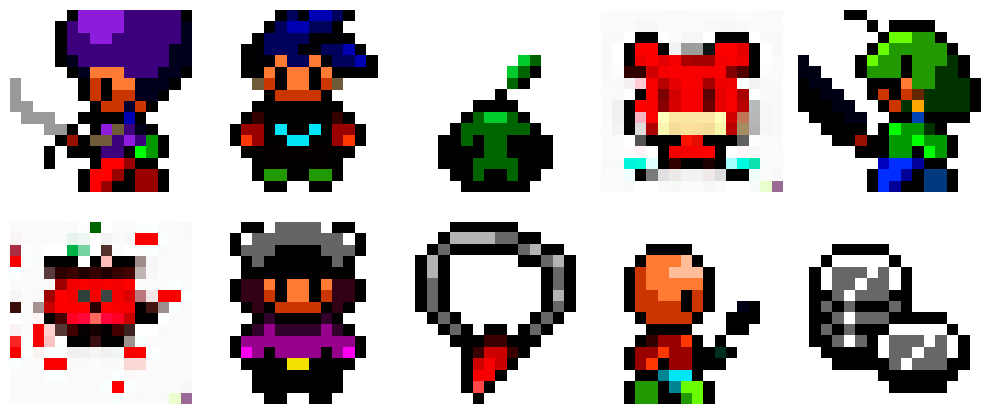

In [11]:
# load dataset and construct optimizer

dataset = CustomDataset("./sprites_1788_16x16.npy", "./sprite_labels_nc_1788_16x16.npy", transform, null_context=False)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)

optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

def plot_sample_images(loader):

    images,_ = next(iter(loader))

    plt.figure(figsize=(10, 5))

    for i in range(10):

        plt.subplot(2, 5, i + 1)

        plt.imshow(images[i].permute(1, 2, 0).cpu().numpy())

        plt.axis("off")

        plt.tight_layout()

    plt.show()

plot_sample_images(dataloader)

In [12]:
# helper function: perturbs an image to a specified noise level

def perturb_input(x, t, noise):

    return ab_t.sqrt()[t, None, None, None] * x + (1 - ab_t[t, None, None, None]) * noise

In [18]:
# training without context code

# set into train mode

nn_model.train()

for ep in range(n_epoch):

    print(f'epoch {ep}')


    # linearly decay learning rate

    optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)


    pbar = tqdm(dataloader, mininterval=2 )

    for x, _ in pbar: # x: images

        optim.zero_grad()

        x = x.to(device)


        # perturb data

        noise = torch.randn_like(x)

        t = torch.randint(1, timesteps + 1, (x.shape[0],)).to(device)

        x_pert = perturb_input(x, t, noise)


        # use network to recover noise

        pred_noise = nn_model(x_pert, t / timesteps)


        # loss is mean squared error between the predicted and true noise

        loss = F.mse_loss(pred_noise, noise)

        loss.backward()


        optim.step()

        # save model periodically

        if ep%4==0 or ep == int(n_epoch-1):

            if not os.path.exists(save_dir):

                os.mkdir(save_dir)

                torch.save(nn_model.state_dict(), save_dir + f"model_{ep}.pth")

                print('saved model at ' + save_dir + f"model_{ep}.pth")

epoch 0


  0%|          | 3/894 [00:06<31:35,  2.13s/it]  


KeyboardInterrupt: 

In [16]:
# load in model weights and set to eval mode

nn_model.load_state_dict(torch.load(f"{save_dir}/model_0.pth", map_location=device))

nn_model.eval()

print("Loaded in Model")

# visualize samples

plt.clf()

samples, intermediate_ddpm = sample_ddpm(32)

animation_ddpm = plot_sample(intermediate_ddpm,32,4,save_dir, "ani_run", None, save=False)

HTML(animation_ddpm.to_jshtml())

C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_15632\3640273258.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nn_model.load_state_dict(torch.load(f"{save_dir}/mo

FileNotFoundError: [Errno 2] No such file or directory: 'model//model_0.pth'

In [ ]:
# define sampling function for DDIM

# removes the noise using ddim

def denoise_ddim(x, t, t_prev, pred_noise):

    ab = ab_t[t]

    ab_prev = ab_t[t_prev]


    x0_pred = ab_prev.sqrt() / ab.sqrt() * (x - (1 - ab).sqrt() * pred_noise)

    dir_xt = (1 - ab_prev).sqrt() * pred_noise

    return x0_pred + dir_xt

In [ ]:
# sample quickly using DDIM

@torch.no_grad()

def sample_ddim(n_sample, n=20):

    # x_T ~ N(0, 1), sample initial noise

    samples = torch.randn(n_sample, 3, height, height).to(device)

    # array to keep track of generated steps for plotting

    intermediate = []

    step_size = timesteps // n

    for i in range(timesteps, 0, -step_size):

        print(f'sampling timestep {i:3d}', end='\r')

        # reshape time tensor

        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        eps = nn_model(samples, t) # predict noise e_(x_t,t)

        samples = denoise_ddim(samples, i, i - step_size, eps)

        intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)

    return samples, intermediate

# visualize samples

plt.clf()

samples, intermediate = sample_ddim(32, n=25)

animation_ddim = plot_sample(intermediate,32,4,save_dir, "ani_run", None, save=False)

HTML(animation_ddim.to_jshtml())